In [ ]:
!pip install scikit-optimize

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split,GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor, plot_importance

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import shap
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

# 교통량 (k=1), 전기차 (k=2)

In [5]:
df_my = pd.read_excel('격자+교통량 데이터(k=1)+전기자동차 대수 데이터(k=2).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## nested CV

In [62]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor()
params={'n_estimators':[30,50,100],'learning_rate':[0.03,0.05,0.07],
                      'max_depth':[1,2,3],'gamma':[0.3,0.5,0.7], 'min_child_weight':[3,5,7],
                      'subsample':[0.75,0.8,0.85],'colsample_bytree':[0.85,0.9,0.95]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_xgb = GridSearchCV(estimator=XGB_reg, param_grid=params, scoring='neg_mean_squared_error', cv=inner_cv)
gs_xgb.fit(X_train, y_train)

print(gs_xgb.best_params_)
print(f'XGB boost MSE: {(-1*gs_xgb.best_score_).round(4)}')
gs_best = gs_xgb.best_estimator_
scores_xgb = cross_val_score(gs_xgb, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV MSE: %.4f +/- %.3f' % (np.mean(-1*scores_xgb), np.std(-1*scores_xgb)))

{'colsample_bytree': 0.85, 'gamma': 0.7, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 0.75}
XGB boost MSE: 0.9567
CV MSE: 1.0117 +/- 0.284


## best estimator 를 이용하여 $R^2$ 계산

In [6]:
XGB_reg_best = XGBRegressor(subsample= 0.75, n_estimators= 50, min_child_weight= 7, max_depth= 2, learning_rate=  0.07, gamma= 0.7, colsample_bytree = 0.85)
# Add silent=True to avoid printing out updates with each cycle
XGB_reg_best.fit(X_train, y_train, verbose=False)

y_train_pred=XGB_reg_best.predict(X_train)
y_test_pred=XGB_reg_best.predict(X_test)

print('RMSE train : %0.3f, test : %0.3f' %(np.sqrt(mean_squared_error(y_train, y_train_pred)) , np.sqrt(mean_squared_error(y_test,y_test_pred))))
print('R2 score train : %0.3f, test : %0.3f' %(r2_score(y_train, y_train_pred) , r2_score(y_test,y_test_pred)))

RMSE train : 0.836, test : 1.135
R2 score train : 0.478, test : 0.293


## shap plot 을 이용하여 변수 중요도 추출

In [7]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(XGB_reg_best)
shap_values = explainer.shap_values(X_train)

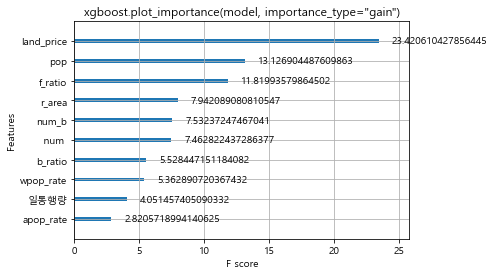

In [8]:
xgboost.plot_importance(XGB_reg_best, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

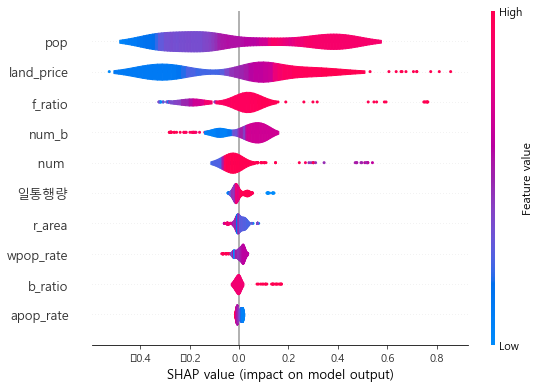

In [9]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# 교통량 (k=1), 전기차 (k=3)

In [10]:
df_my = pd.read_excel('격자+교통량 데이터(k=1)+전기자동차 대수 데이터(k=3).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
df_my.shape

(575, 11)

## nested CV

In [39]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor()
params={'n_estimators':[30,50,100],'learning_rate':[0.03,0.05,0.07],
                      'max_depth':[1,2,3],'gamma':[0.3,0.5,0.7], 'min_child_weight':[3,5,7],
                      'subsample':[0.75,0.8,0.85],'colsample_bytree':[0.85,0.9,0.95]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_xgb = GridSearchCV(estimator=XGB_reg, param_grid=params, scoring='neg_mean_squared_error', cv=inner_cv)
gs_xgb.fit(X_train, y_train)

print(gs_xgb.best_params_)
print(f'XGB boost: {(-1*gs_xgb.best_score_).round(4)}')

scores_xgb = cross_val_score(gs_xgb, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_xgb), np.std(-1*scores_xgb)))

{'colsample_bytree': 0.85, 'gamma': 0.7, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.75}
XGB boost: 0.9495
CV mean squared error: 1.0081 +/- 0.278


## best estimator 를 이용하여 $R^2$ 계산

In [12]:
XGB_reg_best = XGBRegressor(subsample= 0.75, n_estimators= 50, min_child_weight= 5, max_depth= 2, learning_rate=  0.07, gamma= 0.7, colsample_bytree = 0.85)
# Add silent=True to avoid printing out updates with each cycle
XGB_reg_best.fit(X_train, y_train, verbose=False)

y_train_pred=XGB_reg_best.predict(X_train)
y_test_pred=XGB_reg_best.predict(X_test)

print('RMSE train : %0.3f, test : %0.3f' %(np.sqrt(mean_squared_error(y_train, y_train_pred)) , np.sqrt(mean_squared_error(y_test,y_test_pred))))
print('R2 score train : %0.3f, test : %0.3f' %(r2_score(y_train, y_train_pred) , r2_score(y_test,y_test_pred)))

RMSE train : 0.832, test : 1.131
R2 score train : 0.483, test : 0.298


In [13]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(XGB_reg_best)
shap_values = explainer.shap_values(X_train)

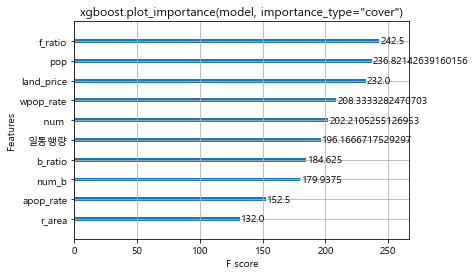

In [14]:
xgboost.plot_importance(XGB_reg_best, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

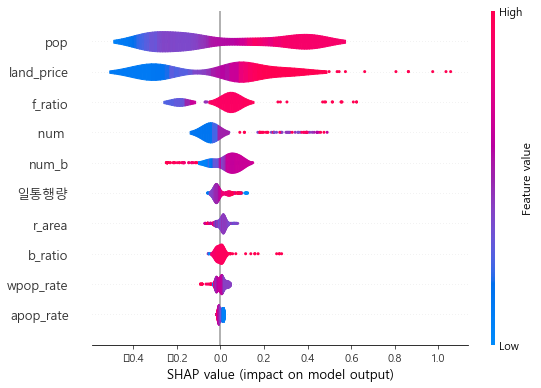

In [15]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# 교통량 (k=2), 전기차 (k=2)

In [16]:
df_my = pd.read_excel('격자+교통량 데이터(k=2)+전기자동차 대수 데이터(k=2).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
df_my.shape

(575, 11)

## nested CV

In [9]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor()
params={'n_estimators':[30,50,100],'learning_rate':[0.03,0.05,0.07],
                      'max_depth':[1,2,3],'gamma':[0.3,0.5,0.7], 'min_child_weight':[3,5,7],
                      'subsample':[0.75,0.8,0.85],'colsample_bytree':[0.85,0.9,0.95]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_xgb = GridSearchCV(estimator=XGB_reg, param_grid=params, scoring='neg_mean_squared_error', cv=inner_cv)
gs_xgb.fit(X_train, y_train)

print(gs_xgb.best_params_)
print(f'XGB boost: {(-1*gs_xgb.best_score_).round(4)}')

scores_xgb = cross_val_score(gs_xgb, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_xgb), np.std(-1*scores_xgb)))

{'colsample_bytree': 0.9, 'gamma': 0.3, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 0.85}
XGB boost: 0.9574
CV mean squared error: 1.0046 +/- 0.273


## best estimator 를 이용하여 $R^2$ 계산

In [18]:
XGB_reg_best = XGBRegressor(subsample= 0.85, n_estimators= 50, min_child_weight= 7, max_depth= 2, learning_rate=  0.07, gamma= 0.3, colsample_bytree = 0.9)
# Add silent=True to avoid printing out updates with each cycle
XGB_reg_best.fit(X_train, y_train, verbose=False)

y_train_pred=XGB_reg_best.predict(X_train)
y_test_pred=XGB_reg_best.predict(X_test)

print('RMSE train : %0.3f, test : %0.3f' %(np.sqrt(mean_squared_error(y_train, y_train_pred)) , np.sqrt(mean_squared_error(y_test,y_test_pred))))
print('R2 score train : %0.3f, test : %0.3f' %(r2_score(y_train, y_train_pred) , r2_score(y_test,y_test_pred)))

RMSE train : 0.836, test : 1.143
R2 score train : 0.478, test : 0.283


In [19]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(XGB_reg_best)
shap_values = explainer.shap_values(X_train)

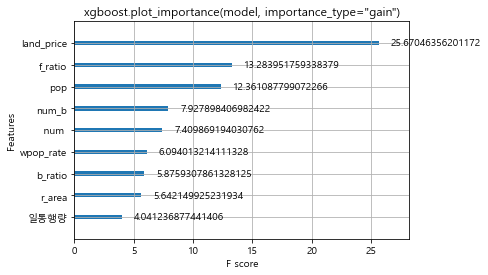

In [20]:
xgboost.plot_importance(XGB_reg_best, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

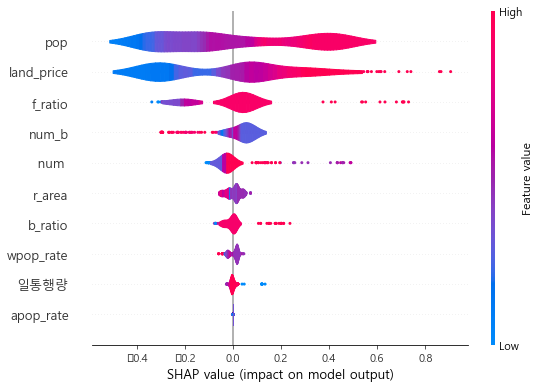

In [21]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# 교통량 (k=2), 전기차 (k=3)

In [53]:
df_my = pd.read_excel('격자+교통량 데이터(k=2)+전기자동차 대수 데이터(k=3).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [54]:
df_my.shape

(575, 11)

## nested CV

In [13]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor()
params={'n_estimators':[30,50,100],'learning_rate':[0.03,0.05,0.07],
                      'max_depth':[1,2,3],'gamma':[0.3,0.5,0.7], 'min_child_weight':[3,5,7],
                      'subsample':[0.75,0.8,0.85],'colsample_bytree':[0.85,0.9,0.95]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_xgb = GridSearchCV(estimator=XGB_reg, param_grid=params, scoring='neg_mean_squared_error', cv=inner_cv)
gs_xgb.fit(X_train, y_train)

print(gs_xgb.best_params_)
print(f'XGB boost: {(-1*gs_xgb.best_score_).round(4)}')

scores_xgb = cross_val_score(gs_xgb, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_xgb), np.std(-1*scores_xgb)))

{'colsample_bytree': 0.85, 'gamma': 0.3, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 0.75}
XGB boost: 0.9442
CV mean squared error: 1.0093 +/- 0.279


## best estimator 를 이용하여 $R^2$ 계산

In [55]:
import joblib
XGB_reg_best = XGBRegressor(subsample= 0.75, n_estimators= 50, min_child_weight= 7, max_depth= 2, learning_rate=  0.07, gamma= 0.3, colsample_bytree = 0.85)
# Add silent=True to avoid printing out updates with each cycle
XGB_reg_best.fit(X_train, y_train, verbose=False)

joblib.dump(XGB_reg_best,'./XGB_reg_best(k=2,k=3).pkl')


['./XGB_reg_best(k=2,k=3).pkl']

In [56]:
y_train_pred=XGB_reg_best.predict(X_train)
y_test_pred=XGB_reg_best.predict(X_test)

print('RMSE train : %0.3f, test : %0.3f' %(mean_squared_error(y_train, y_train_pred) , mean_squared_error(y_test,y_test_pred)))
print('R2 score train : %0.3f, test : %0.3f' %(r2_score(y_train, y_train_pred) , r2_score(y_test,y_test_pred)))

RMSE train : 0.700, test : 1.276
R2 score train : 0.478, test : 0.300


In [57]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(XGB_reg_best)
shap_values = explainer.shap_values(X_train)

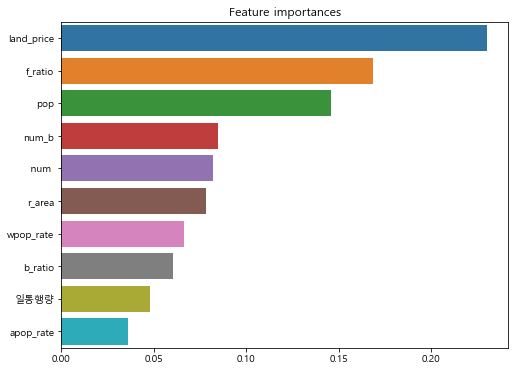

In [58]:
ftr_importances_values = XGB_reg_best.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)  # [:5]
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

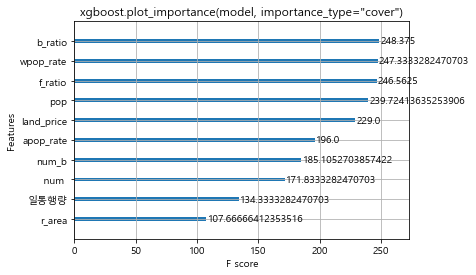

In [51]:
xgboost.plot_importance(XGB_reg_best, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

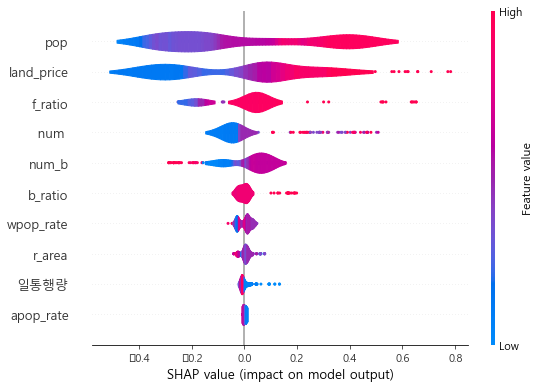

In [50]:
shap.summary_plot(shap_values, X_train, plot_type='violin')